In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("smaildurcan/turkish-license-plate-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'turkish-license-plate-dataset' dataset.
Path to dataset files: /kaggle/input/turkish-license-plate-dataset


In [4]:
import os
import shutil
import random

source_images = "/kaggle/input/turkish-license-plate-dataset/images"
source_labels = "/kaggle/input/turkish-license-plate-dataset/label" 

base_dir = "/content/split_dataset"

train_ratio = 0.8

dirs = [
    'images/train', 'images/val',
    'labels/train', 'labels/val'
]

for d in dirs:
    os.makedirs(os.path.join(base_dir, d), exist_ok=True)

image_files = [f for f in os.listdir(source_images) if f.endswith(('.jpg'))]
random.shuffle(image_files)

split_point = int(len(image_files) * train_ratio)
train_files = image_files[:split_point]
val_files = image_files[split_point:]

def copy_files(files, split_type):
    for img_name in files:
        src_img = os.path.join(source_images, img_name)
        dst_img = os.path.join(base_dir, f'images/{split_type}', img_name)
        shutil.copy(src_img, dst_img)

        label_name = os.path.splitext(img_name)[0] + '.txt'
        src_label = os.path.join(source_labels, label_name)

        if os.path.exists(src_label):
            dst_label = os.path.join(base_dir, f'labels/{split_type}', label_name)
            shutil.copy(src_label, dst_label)

copy_files(train_files, 'train')
copy_files(val_files, 'val')

Dosyalar ayrıştırılıyor...
İşlem Tamamlandı! Veriler /content/split_dataset klasöründe.


In [11]:
import yaml

data = {
    'path': '/content/split_dataset',  
    'train': 'images/train',          
    'val': 'images/val',               
    'nc': 1,                           
    'names': ['plate']                 
}

# Dosyayı Colab içine kaydetme
yaml_file_path = '/content/data.yaml'

with open(yaml_file_path, 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

print(f"data.yaml dosyası başarıyla oluşturuldu: {yaml_file_path}")

data.yaml dosyası başarıyla oluşturuldu: /content/data.yaml


In [12]:
!pip install ultralytics -q

from ultralytics import YOLO
import torch



model = YOLO('yolov8s.pt')

results = model.train(
    data='/content/data.yaml',
    epochs=100,
    patience=15,
    imgsz=640,
    batch=16,
    workers=8,
    device=0,
    optimizer='auto',
    cache=True,
    cos_lr=True,
    name='plate_model'
)

print("Eğitim Tamamlandı! En iyi model şurada: runs/detect/plate_model/weights/best.pt")

Kullanılan Cihaz: GPU ⚡
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=plate_model3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, pl

İncelenen Dosya: 1946.jpg

image 1/1 /content/split_dataset/images/val/1946.jpg: 640x480 1 plate, 45.0ms
Speed: 2.0ms preprocess, 45.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


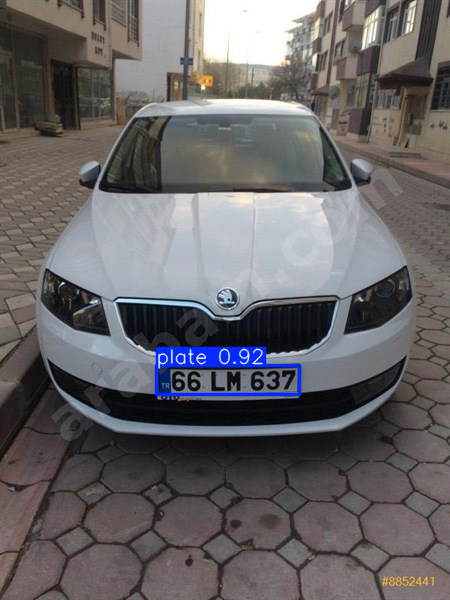

In [14]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow
import os
import random

model_path = '/content/runs/detect/plate_model3/weights/best.pt'

test_images_path = '/content/split_dataset/images/val'

model = YOLO(model_path)

random_file = random.choice(os.listdir(test_images_path))
file_path = os.path.join(test_images_path, random_file)

print(f"İncelenen Dosya: {random_file}")
results = model.predict(file_path, conf=0.40)

res_plotted = results[0].plot()
cv2_imshow(res_plotted)